In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [2]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [3]:
def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
  hasBlack = False
  
  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)

  
  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
    # Check if the color is [0,0,0] that if it is black 
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster 
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
   
  return (occurance_counter,estimator_cluster,hasBlack)
    
    

In [4]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None
  
  # Output list variable to return
  colorInformation = []
  
  
  #Check for Black
  hasBlack =False
  
  # If a mask has be applied, remove th black
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
    
  else:
    occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values()) 
  
 
  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    index = (int(x[0]))
    
    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    # Get the color number into a list
    color = estimator_cluster[index].tolist()
    
    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)
    
    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    
    # Add the dictionary to the list
    colorInformation.append(colorInfo)
    
      
  return colorInformation 

In [5]:

def extractDominantColor(image,number_of_colors=5,hasThresholding=False):
  
  # Quick Fix Increase cluster counter to neglect the black(Read Article) 
  if hasThresholding == True:
    number_of_colors +=1
  
  # Taking Copy of the image
  img = image.copy()
  
  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  # Fit the image
  estimator.fit(img)
  
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  
  

In [6]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation:    
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))
  
    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [7]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

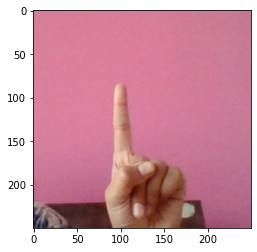

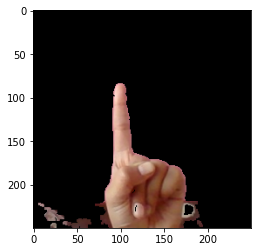

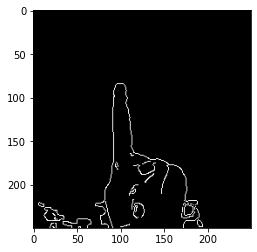

In [11]:
image = cv2.imread("d1/1/28.jpg")
# Resize image to a width of 250
image = imutils.resize(image,width=250)

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()


# Apply Skin Mask
skin = extractSkin(image)
#cv2.imwrite('29.jpg',skin) 
#imgCanny = cv2.Canny(skin, 150, 250)
#imgplot = plt.imshow(skin)
#plt.show()
plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imshow("Canny Image", imgCanny)
plt.imshow(cv2.cvtColor(imgCanny,cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
from scipy import ndimage, misc
import numpy as np
import os
import cv2

outPath = "my_gray/"
path = "my_dataset/"


for image_path in os.listdir(path):
    print(image_path) 
    image_path = os.path.join(path, image_path)
    for image_ in os.listdir(image_path):
        inputpath = os.path.join(image_path, image_)
        image = cv2.imread(inputpath)
        image = imutils.resize(image,width=128)
        skin = extractSkin(image) 
        #skin = cv2.Canny(skin,150,200)
        folder = os.path.basename(image_path)
        
        fullpath = os.path.join(outPath+folder, image_)
        cv2.imwrite(fullpath,skin)

1
2
3
4
5
6
7
8
9


In [1]:
# Realtime Predictions

In [8]:
import keras
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
import imutils
import os
import matplotlib.pyplot as plt

In [12]:
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
model = keras.models.load_model("Numbers_kaggle_dataset_segment.h5")

In [13]:
def classify(image):
    image = cv2.resize(image, (128, 128))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    proba=model.predict(image)
    idx = np.argmax(proba)
    return class_names[idx]

In [17]:
cap = cv2.VideoCapture(0)
while 1:
    ret, img = cap.read()
    img = cv2.flip(img, 1)
    top, right, bottom, left = 100, 250, 400, 550
    roi = img[top:bottom, right:left]
    #roi=cv2.flip(roi,1)
    #gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    #gray = cv2.GaussianBlur(roi, (7, 7), 0)
    gray = extractSkin(roi)
    cv2.imshow('roi',gray)
    alpha=classify(gray)
    cv2.rectangle(img, (left, top), (right, bottom), (0,255,0), 2)
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,alpha,(0,130),font,5,(0,0,255),2)
    #cv2.resize(img,(1000,1000))
    cv2.imshow('img',img)
    key = cv2.waitKey(1) & 0xFF
    if key==ord('q'):
        break;
cap.release()
cv2.destroyAllWindows()